<a href="https://colab.research.google.com/github/manlio99/DeTodoUnPoco/blob/main/Unet_Image_segmentation_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Example Image segmentation with CamVid

https://medium.com/analytics-vidhya/image-segmentation-using-fastai-ddded25f811e

<table align="left"><td>
  <a target="_blank"  href="https://colab.research.google.com/github/TannerGilbert/FastAI-Code-Collection/blob/v1/Image_segmentation_on_CamVid_dataset.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab
  </a>
</td><td>
  <a target="_blank"  href="https://github.com/TannerGilbert/FastAI-Code-Collection/blob/v1/Image_segmentation_on_CamVid_dataset.ipynb">
    <img width=32px src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
</td></table>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install torch==1.4 torchvision==0.5.0
!pip install fastai==1.0.61 

  Using cached torch-1.4.0-cp37-cp37m-manylinux1_x86_64.whl (753.4 MB)
  Using cached torchvision-0.5.0-cp37-cp37m-manylinux1_x86_64.whl (4.0 MB)
  Attempting uninstall: torch
    Found existing installation: torch 1.9.1
    Uninstalling torch-1.9.1:
      Successfully uninstalled torch-1.9.1
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.10.1
    Uninstalling torchvision-0.10.1:
      Successfully uninstalled torchvision-0.10.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.10.0 requires torch==1.9.0, but you have torch 1.4.0 which is incompatible.
fastdebug 0.1.4 requires torch>=1.7.0, but you have torch 1.4.0 which is incompatible.
fastai 2.5.2 requires torch<1.10,>=1.7.0, but you have torch 1.4.0 which is incompatible.
fastai 2.5.2 requires torchvision>=0.8.2, but you have torchvision 0.5.0 which is incompati

In [ ]:
# !pip install fastdebug

# from fastdebug import *

In [ ]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

In [ ]:
path_lbl = "/content/drive/MyDrive/Colab Notebooks/odontologia/mask_folder/etiqueta_molar_premolar_caninos_incisivos/"
path_img = "/content/drive/MyDrive/Colab Notebooks/odontologia/mask_folder/images/"


## Data

In [ ]:
fnames = get_image_files(path_img)
fnames[:3]

[PosixPath('/content/drive/MyDrive/Colab Notebooks/odontologia/mask_folder/images/0.png'),
 PosixPath('/content/drive/MyDrive/Colab Notebooks/odontologia/mask_folder/images/1.png'),
 PosixPath('/content/drive/MyDrive/Colab Notebooks/odontologia/mask_folder/images/2.png')]

In [ ]:
lbl_names = get_image_files(path_lbl)
lbl_names[:3]

[PosixPath('/content/drive/MyDrive/Colab Notebooks/odontologia/mask_folder/etiqueta_molar_premolar_caninos_incisivos/0.png'),
 PosixPath('/content/drive/MyDrive/Colab Notebooks/odontologia/mask_folder/etiqueta_molar_premolar_caninos_incisivos/1.png'),
 PosixPath('/content/drive/MyDrive/Colab Notebooks/odontologia/mask_folder/etiqueta_molar_premolar_caninos_incisivos/2.png')]

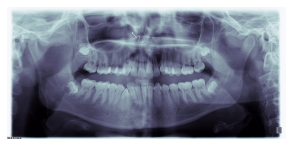

In [ ]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5, 5))

In [ ]:
img.data.max()

tensor(1.)

In [ ]:
# get_y_fn = lambda x: x
get_y_fn = lambda x: path_lbl+f'{x.stem}{x.suffix}'

In [ ]:
img_f

PosixPath('/content/drive/MyDrive/Colab Notebooks/odontologia/mask_folder/images/0.png')

In [ ]:
get_y_fn(img_f)

'/content/drive/MyDrive/Colab Notebooks/odontologia/mask_folder/etiqueta_molar_premolar_caninos_incisivos/0.png'

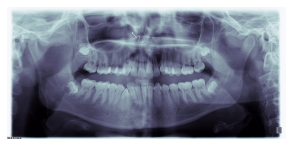

In [ ]:
img = open_image(img_f)
img.show(figsize=(5,5))

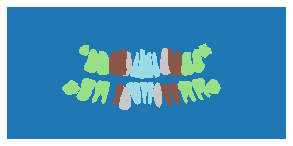

In [ ]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5, 5), alpha=1)

In [ ]:
mask.data.max()

tensor(4)

In [ ]:
src_size = np.array(mask.shape[1:])
src_size, mask.data

(array([302, 640]), tensor([[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]]))

In [ ]:
codes = np.loadtxt('/content/drive/MyDrive/Colab Notebooks/odontologia/mask_folder/labels.txt', dtype=str)
# codes = np.array(["molares", "premolares", "caninos", "incisivos"], dtype=str)
codes

array(['encia', 'molares', 'premolares', 'caninos', 'incisivos'], dtype='<U10')

## Datasets

adapte el dataset al tamaño de la imagen mas **pequeña**

In [ ]:
size = (3, 302, 640)# src_size  #(360, 480) //2

free = gpu_mem_get_free_no_cache()
# if free > 8200: 
#   bs=8
# else:
#   bs=4
bs=4
print(f"using bs={bs}, have {free} MB of GPU RAM free")
size

using bs=4, have 10764 MB of GPU RAM free


(3, 302, 640)

In [ ]:
src = (SegmentationItemList.from_folder(path_img)
        .split_by_rand_pct(seed=1995)
       .label_from_func( get_y_fn, classes=codes)
       )
# .split_by _fname_file('../valid.txt')  .split_none()

In [ ]:
# src.transform(size=224, tfm_y=True)
src.get_processors

<bound method LabelLists.get_processors of LabelLists;

Train: LabelList (44 items)
x: SegmentationItemList
Image (3, 302, 640),Image (3, 302, 640),Image (3, 1536, 3256),Image (3, 302, 640),Image (3, 1536, 3256)
y: SegmentationLabelList
ImageSegment (1, 302, 640),ImageSegment (1, 302, 640),ImageSegment (1, 1536, 3256),ImageSegment (1, 302, 640),ImageSegment (1, 1536, 3256)
Path: /content/drive/MyDrive/Colab Notebooks/odontologia/mask_folder/images;

Valid: LabelList (10 items)
x: SegmentationItemList
Image (3, 302, 640),Image (3, 1536, 3256),Image (3, 1536, 3256),Image (3, 1536, 3256),Image (3, 302, 640)
y: SegmentationLabelList
ImageSegment (1, 302, 640),ImageSegment (1, 1536, 3256),ImageSegment (1, 1536, 3256),ImageSegment (1, 1536, 3256),ImageSegment (1, 302, 640)
Path: /content/drive/MyDrive/Colab Notebooks/odontologia/mask_folder/images;

Test: None>

In [ ]:
data = (src.transform(size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

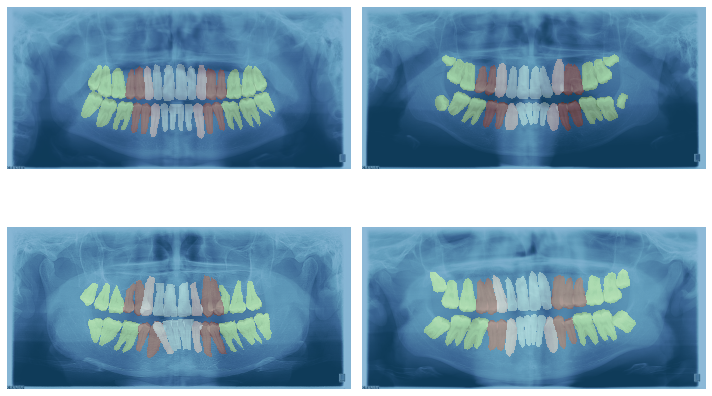

In [ ]:
data.show_batch(2, figsize=(10, 7))

## Model

In [ ]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id.values()

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [ ]:
metrics = acc_camvid

In [ ]:
wd = 1e-4

In [ ]:
# create unet
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

In [ ]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


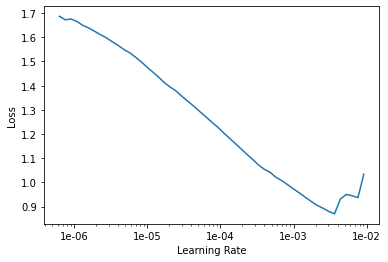

In [ ]:
learn.recorder.plot()

In [ ]:
lr = 3e-3

In [ ]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.9)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.894355,0.563004,0.824477,00:21
1,0.664104,0.398758,0.847967,00:21
2,0.528361,0.257731,0.897442,00:21
3,0.468239,0.293547,0.874300,00:22
4,0.410769,0.226596,0.914529,00:21
5,0.365461,0.257078,0.901082,00:21
6,0.504947,0.718976,0.824507,00:22
7,0.599718,0.647444,0.824507,00:20
8,0.659338,0.656201,0.824506,00:21
9,0.638658,0.457506,0.826599,00:21


In [ ]:
learn.save('/content/drive/MyDrive/Colab Notebooks/odontologia/mask_folder/fastai_dientes_original_1')


# learn.load('/content/drive/MyDrive/Colab Notebooks/odontologia/mask_folder/fastai_dientes_1');



## Aqui se ve la necesidad de cambiar la loss

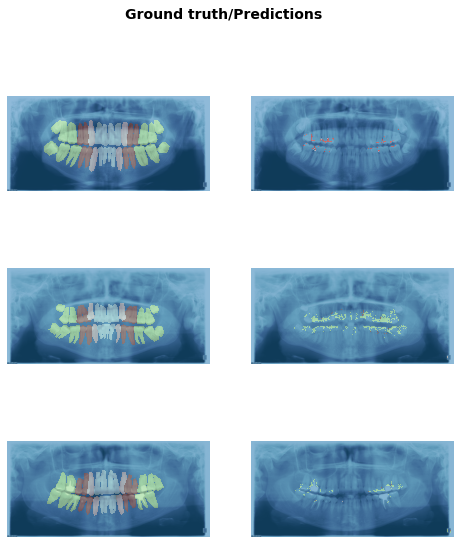

In [ ]:
learn.show_results(rows=3, figsize=(8, 9))

In [ ]:
learn.unfreeze()

In [ ]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


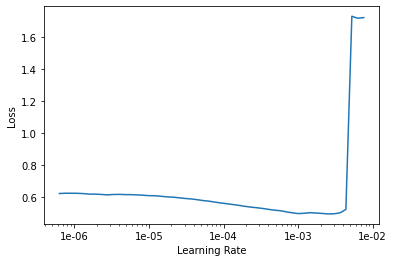

In [ ]:
learn.recorder.plot()

## Aqui no sé si esta bien el lr pero los resultados son mejores

In [ ]:
learn.fit_one_cycle(12, slice(lr/300, lr/3), pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.429449,0.379052,0.851252,00:22
1,0.391183,0.335781,0.869577,00:22
2,0.362191,0.298084,0.886508,00:21
3,0.336381,0.265171,0.891459,00:22
4,0.307240,0.279740,0.884694,00:22
5,0.285397,0.209871,0.918062,00:22
6,0.262351,0.196991,0.919755,00:22
7,0.245123,0.189381,0.921301,00:22
8,0.226784,0.147142,0.941240,00:22
9,0.211644,0.158135,0.938445,00:22


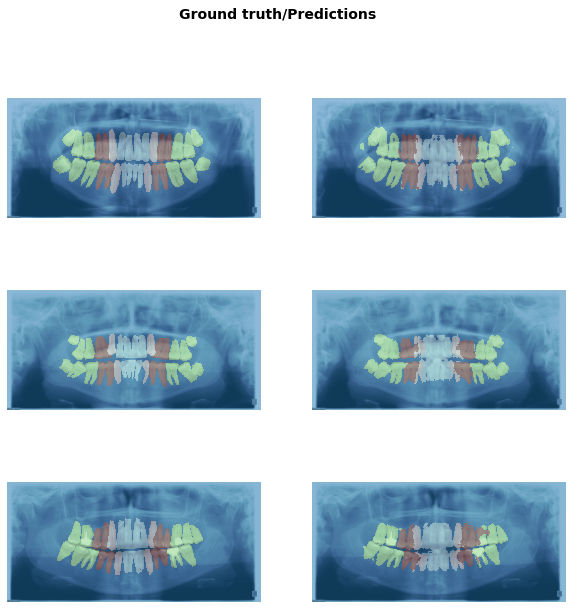

In [ ]:
learn.show_results(rows=3, figsize=(10, 10))

In [ ]:
learn.save('camvid-stage-2')

## Train on bigger images

In [ ]:
size = (size[0], int(size[1]*1.5), int(size[2]*1.5))

In [ ]:
size

(3, 453, 960)

In [ ]:
learn.destroy()

# size = size *1.5

free = gpu_mem_get_free_no_cache()
if free > 8200: 
  bs=3
else: 
  bs=1
print(f"using bs={bs}, have {free}MB of GPU RAM free")

this object has been destroyed
using bs=3, have 10764MB of GPU RAM free


In [ ]:
data = (src.transform(size=size , tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [ ]:
data.show_batch(2, figsize=(10, 7))

In [ ]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

In [ ]:
learn.load('camvid-stage-2');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


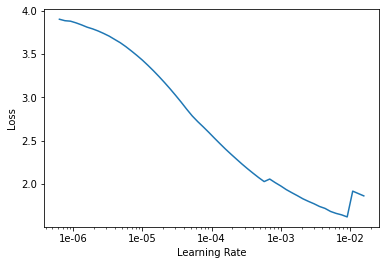

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [ ]:
lr = 3e-4

In [ ]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,1.996857,0.973546,0.760681,00:51
1,1.345649,0.722083,0.819330,00:43
2,1.023454,0.494383,0.834638,00:43
3,0.796992,0.349327,0.865002,00:42
4,0.640883,0.266558,0.899716,00:43
5,0.520592,0.345967,0.872503,00:43
6,0.467168,0.349274,0.889978,00:43
7,0.463453,0.661381,0.862748,00:43
8,118.084404,19.197794,0.824064,00:43
9,88.246986,0.859620,0.824023,00:42


In [ ]:
learn.save('camvid-big-stage-1')

de nuevo problemas con el loss

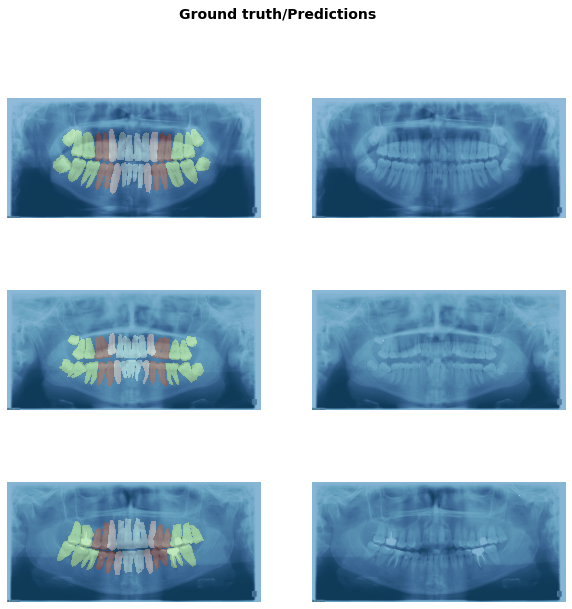

In [ ]:
learn.show_results(rows=3, figsize=(10, 10))

In [ ]:
learn.unfreeze()

In [ ]:
learn.fit_one_cycle(10, slice(1e-6, lr/10))

epoch,train_loss,valid_loss,acc_camvid,time
0,0.869768,0.776222,0.823884,00:46
1,0.799011,0.654789,0.823330,00:44
2,0.702352,0.424301,0.871803,00:45
3,0.944907,4.843535,0.834320,00:45
4,7.451096,62.416924,0.817815,00:45
5,62.075672,468.782959,0.821728,00:44
6,274.570099,1512.344482,0.699937,00:44
7,784.013428,2987.631592,0.700365,00:44
8,1481.995850,3798.468018,0.759867,00:44
9,2110.983154,3832.569824,0.725648,00:44


In [ ]:
learn.save('stage-2-big')

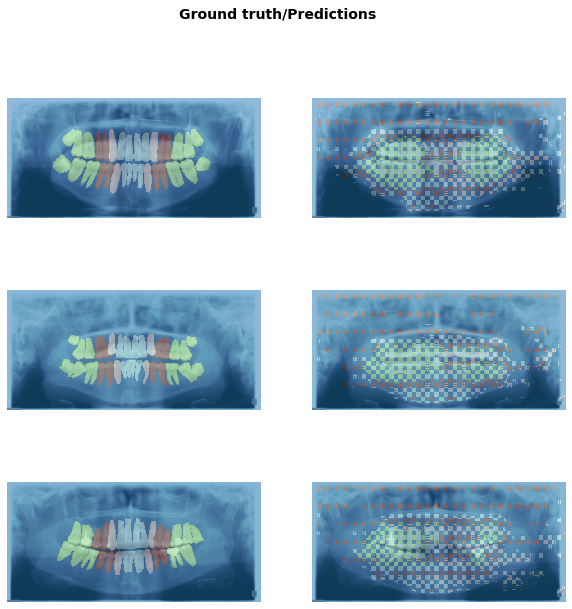

In [ ]:
learn.show_results(rows=3, figsize=(10, 10))

## Interpretation

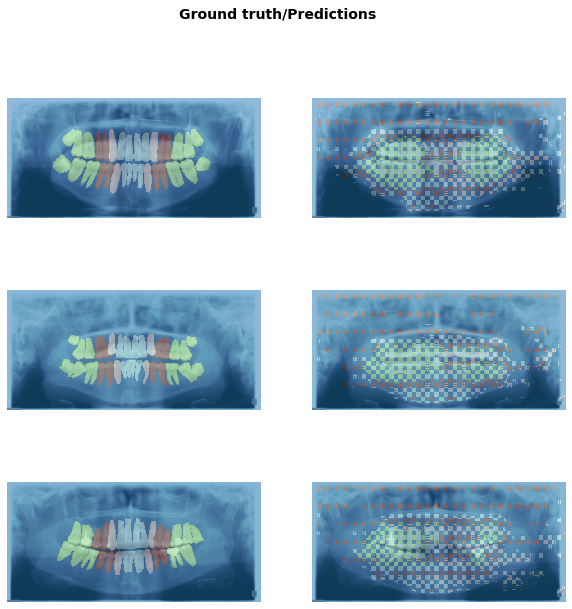

In [ ]:
learn.show_results(rows=3, figsize=(10, 10))